In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier as Knc
import skimage.transform as skt
from sklearn.metrics.pairwise import cosine_similarity
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.misc import imread, imresize

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Récupération des données

In [2]:
#récupère les différents chemins de toutes les données

def contenu_dossier(path_dossier):
    
    path = path_dossier

    liste_noms = os.listdir(path_dossier)
    liste_chemins = []
    for name in liste_noms:
        if name[-4] != '.':
            liste_chemins2 = contenu_dossier(path_dossier+'/'+name)
            liste_chemins += liste_chemins2
        if name[-4:] == '.jpg':
            liste_chemins += [path_dossier+"/"+name]
        else:
            pass
        
    return liste_chemins
    

# Calcul des features

In [3]:
#importation du réseau de neurones pré-entrainé
model = VGG16(include_top=False, weights='imagenet')

In [4]:
#calcul des features grace au réseau de neurones
def compute_features(chemins):
    n = len(chemins)
    features = np.zeros((n,25088))
    
    for i in range(n):
        image = np.expand_dims(preprocess_input(skt.resize(plt.imread(chemins[i]),(224,224,3), mode = 'reflect', preserve_range = True)),axis=0)
        features[i,:] = model.predict(image).ravel()
    return features

In [5]:
#GENERATION DE TOUS LES CHEMINS
l_ring = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/ring")
l_bracelet = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/bracelet")
l_necklace = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/necklace")
l_earring = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery/earring")

In [6]:
#GENERATION DE TOUS LES FEATURES
features_ring = compute_features(l_ring)
features_bracelet = compute_features(l_bracelet)
features_necklace = compute_features(l_necklace)
features_earring = compute_features(l_earring)

In [7]:
#Création du dictionnaire contenant : 
# - le chemin de l'image
# - le type du bijou
# - les features associées
# - son numéro dans sa catégorie
# - son numéro dans l'ensemble des bijoux

bijoux_complet = []
index = 0
for i in range(len(l_ring)):
    bijoux_complet += [{'image' : l_ring[i], 'type' : "ring", 'features' : features_ring[i], 'numero' : i, 'index' : index}]
    index += 1
    
for i in range(len(l_earring)):
    bijoux_complet += [{'image' : l_earring[i], 'type' : "earring", 'features' : features_earring[i], 'numero' : i, 'index' : index}]
    index += 1
    
for i in range(len(l_bracelet)):
    bijoux_complet += [{'image' : l_bracelet[i], 'type' : "bracelet", 'features' : features_bracelet[i], 'numero' : i, 'index' : index}]
    index += 1
    
for i in range(len(l_necklace)):
    bijoux_complet += [{'image' : l_necklace[i], 'type' : "necklace", 'features' : features_necklace[i], 'numero' : i, 'index' : index}]
    index += 1


In [8]:
#Création du dataframe contenant le dictionnaire
df_bijoux = pd.DataFrame(bijoux_complet)

# Recherche des k plus proches voisins

In [9]:
#Tri des voisins en fonction de la distance croissante avec la méthode des k plus proches voisins
def trouve_voisins(df_bijoux, indice, nom="", distance="euclidean"):
    f = np.vstack(df_bijoux.loc[:,'features']) #récupération des features du data frame
    n = len(f)
    cible = np.zeros(n) #mise à zéro de la cible (inutile ici)
    data_knn = Knc(n, metric=distance)
    data_knn.fit(f, cible)
    if nom != "": #cas particulier où l'indice passé en entrée ne correspond pas à l'index mais au numéro
        bijou_bon = df_bijoux[df_bijoux['numero']==indice]
        bijou_bon = bijou_bon[bijou_bon['type']==nom]
        indice = bijou_bon['index']
    return data_knn.kneighbors(f[indice].reshape(1,-1))

In [64]:
#fonction utile si on utilise la fonction knn
def affichage_voisins(df_bijoux, diff_cat, k, indice, voisins, type_bijou="", cat_cible=""):
    
    """
    affichage pour l'utilisation de knn
    :param df_bijoux: dataframe contenant les données
    :param diff_cat: si TRUE --> on a des résultats d'une autre catégorie
    :param k: nombre de voisins voulus
    :param indice : indice du bijou témoin
    :param voisins : sortie de knn
    :param type_bijou : catégorie d'appartenance du bijou témoin
    :param cat_cible : catégorie d'appartenance des résultats
    :return: l'affichage des k voisins répondant aux critères précédents
    """
    
    # Vérification de la faisabilité
    if diff_cat and type_bijou==cat_cible :
        diff_cat=False
    
    
   # Affichage en gros de l'image principale
    plt.figure()
    
    if type_bijou != "" : #dans le cas où on travaille avec le numéro
        bijou_cible = df_bijoux[df_bijoux['numero']==indice]
        bijou_cible = bijou_cible[bijou_cible['type']==type_bijou]
        plt.imshow(plt.imread(bijou_cible['image'].values[0]))
       
    
       
    else: #cas où on travaille avec l'indice
        bijou_cible = df_bijoux[df_bijoux['index']==indice]
        plt.imshow(plt.imread(bijou_cible['image'].values[0]))
    
    plt.title("distance : " + str(voisins[0][0][0])) #affichage du titre
    plt.savefig('bijoux 3a same cat knn.png')
    plt.show()
    
    # Affichage des autres au-dessous
    lines = k//4
    fig = plt.figure(figsize = (15,15))
    
    n = df_bijoux.shape[0]
    N = 0
    i = 1
    
    if diff_cat and cat_cible=="" : #si on veut des bijoux "autre" dans tout le data set
        while N<k and i<n : #tant que on n'a pas nos k voisins
            num = voisins[1][0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]

            if image_affiche['type'].values[0] != type_bijou: #on ne garde ce bijou que s'il est "autre"
                fig.add_subplot(lines+1, 4, N+1)
                plt.imshow(plt.imread(image_affiche['image'].values[0]))
                plt.title("distance : " + str(voisins[0][0][i])) #affichage du titre
                N += 1

            i += 1
            
            
    elif diff_cat and cat_cible!="" : #si on veut des bijoux "autre" dans une catégorie précise
        while N<k and i<n : #tant que on n'a pas nos k voisins
            num = voisins[1][0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]

            if image_affiche['type'].values[0] != type_bijou: #on ne garde ce bijou que s'il est "autre"
                if image_affiche['type'].values[0] == cat_cible: #on ne garde ce bijou que s'il est dans la catégorie ciblée
                    fig.add_subplot(lines+1, 4, N+1)
                    plt.imshow(plt.imread(image_affiche['image'].values[0]))
                    plt.title("distance : " + str(voisins[0][0][i])) #affichage du titre
                    N += 1

            i += 1
            
        
        
    elif (not diff_cat and type_bijou != "") : #cas ou on ne se concentre que sur une catégorie
        while N<k and i<n : #tant qu'on a pas nos k voisins
            num = voisins[1][0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]

            if image_affiche['type'].values[0] == type_bijou: 
                #on ne garde le bijou que s'il est de la même catégaorie que celle placée en entrée
                fig.add_subplot(lines+1, 4, N+1)
                plt.imshow(plt.imread(image_affiche['image'].values[0]))
                plt.title("distance : " + str(voisins[0][0][i])) #affichage du titre
                N += 1

            i += 1
        
        
    else : #cas où on travaille sur l'ensemble des données 
        for i in range (1, k+1): #on affiche les k premières images car elles sont déjà bien classées
            fig.add_subplot(lines+1, 4, i)
            num = voisins[1][0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]
            plt.imshow(plt.imread(image_affiche['image'].values[0]))
            plt.title("distance : " + str(voisins[0][0][i])) #affichage du titre
        
    plt.tight_layout()
    plt.savefig('bijoux 3b same cat knn.png')
    plt.show()
    
    

In [74]:
indice = 15
diff_cat = True
k = 8
nom = "ring"
cat_cible = "earring"

In [75]:
voisins = trouve_voisins(df_bijoux, indice, nom)

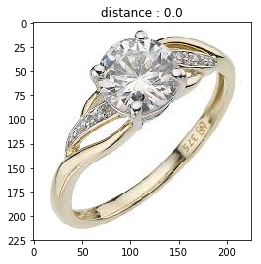

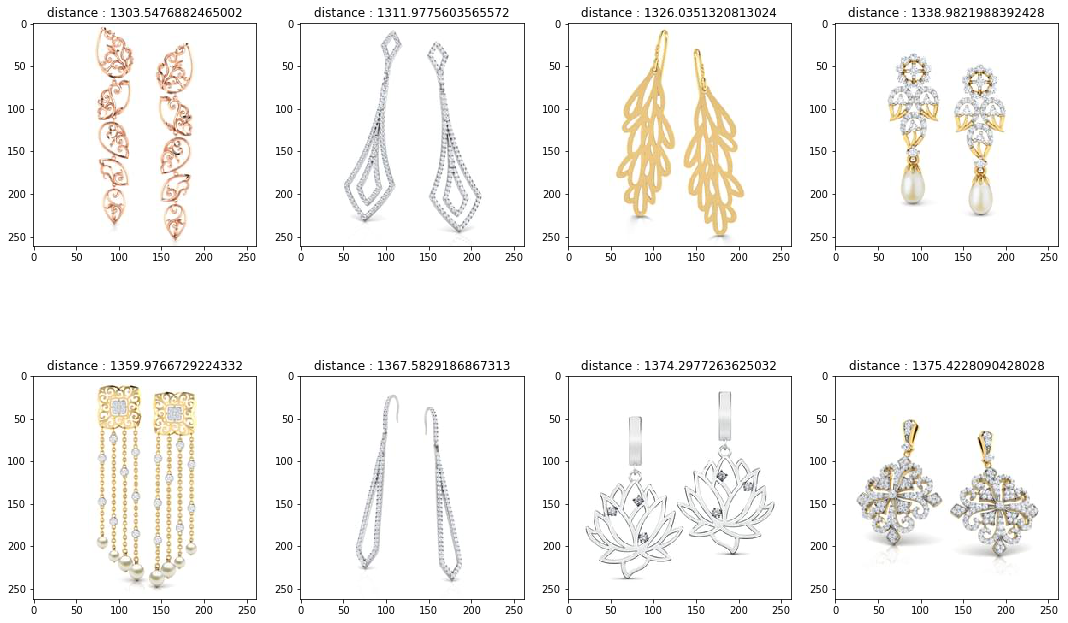

In [76]:
affichage_voisins(df_bijoux, diff_cat, k, indice, voisins, nom, cat_cible)

# Recherche par similarités

In [14]:
#Classement des données en fonction de leur similarité
def cosine_voisins(df_bijoux, indice, nom=""):
    f = np.vstack(df_bijoux.loc[:,'features']) #récupération des features du data frame
    distance_totale = cosine_similarity(f, f)
    if nom != "": #cas où on travaille avec les numéros et non les index
        bijou_bon = df_bijoux[df_bijoux['numero']==indice]
        bijou_bon = bijou_bon[bijou_bon['type']==nom]
        indice = bijou_bon['index']
    voisins = np.argsort(-distance_totale[indice,:]) #récupération des voisins du bijou en argument
    distance = distance_totale[indice, voisins] #récupération des distances du bijou en argument
   
    return distance.reshape(1,-1), voisins.reshape(1,-1)

In [94]:
#Affichage des résultats lorsqu'on a recherché avec cosine
def affichage_cosine(df_bijoux, diff_cat, k, indice, voisins, distance, type_bijou="", cat_cible=""):
    
    """
    affichage pour l'utilisation de cosine similarity
    :param df_bijoux: dataframe contenant les données
    :param diff_cat: si TRUE --> on a des résultats d'une autre catégorie
    :param k: nombre de voisins voulus
    :param indice : indice du bijou témoin
    :param voisins : sortie de cosine_voisins
    :param voisins : sortie de cosine_voisins
    :param type_bijou : catégorie d'appartenance du bijou témoin
    :param cat_cible : catégorie d'appartenance des résultats
    :return: l'affichage des k voisins répondant aux critères précédents
    """
    
    # Vérification de la faisabilité
    if diff_cat and type_bijou==cat_cible :
        diff_cat=False
    
    # Affichage en gros de l'image principale
    plt.figure()
    if nom != "" : #cas où on travaille avec les numéros
        bijou_cible = df_bijoux[df_bijoux['numero']==indice]
        bijou_cible = bijou_cible[bijou_cible['type']==type_bijou]
        plt.imshow(plt.imread(bijou_cible['image'].values[0]))
       
    
       
    else: #cas où on travaille avec les index
        bijou_cible = df_bijoux[df_bijoux['index']==indice]
        plt.imshow(plt.imread(bijou_cible['image'].values[0]))
    plt.title("similarité : " + str(distance[0][0]))
    plt.savefig('bijoux 3a same cat cosine.png')
    plt.show()
    
  
    
    # Affichage des autres au-dessous
    lines = k//4
    fig = plt.figure(figsize = (15,15))
    
    n = df_bijoux.shape[0]
    N = 0
    i = 1
    
    if diff_cat and cat_cible=="": #si on veut des bijoux d'une autre catégorie dans tout le data set      
        while N<k and i<n : #tant que on n'a pas nos k voisins
            num = voisins[0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]

            if image_affiche['type'].values[0] != type_bijou: #on ne garde l'image que si elle a un type différent
                fig.add_subplot(lines+1, 4, N+1)
                plt.imshow(plt.imread(image_affiche['image'].values[0]))
                plt.title("similarité : " + str(distance[0][i]))
                N += 1

            i += 1
            
            
    if diff_cat and cat_cible!="": #si on veut des bijoux d'une autre catégorie dans une catégorie spécifique      
        while N<k and i<n : #tant que on n'a pas nos k voisins
            num = voisins[0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]

            if image_affiche['type'].values[0] != type_bijou: #on ne garde l'image que si elle a un type différent
                if image_affiche['type'].values[0] == cat_cible: #on ne garde l'image que si elle est du bon type
                    fig.add_subplot(lines+1, 4, N+1)
                    plt.imshow(plt.imread(image_affiche['image'].values[0]))
                    plt.title("similarité : " + str(distance[0][i]))
                    N += 1

            i += 1
            
            
    elif (not diff_cat and type_bijou != "") : #cas où on est que sur une seule catégorie       
        while N<k and i<n : #tant que on n'a pas nos k voisins
            num = voisins[0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]

            if image_affiche['type'].values[0] == type_bijou: #on ne garde l'image que si elle est du même type
                fig.add_subplot(lines+1, 4, N+1)
                plt.imshow(plt.imread(image_affiche['image'].values[0]))
                plt.title("similarité : " + str(distance[0][i]))
                N += 1

            i += 1
        
        
    else : #cas où on travaille sur l'ensemble des données
        for i in range (1, k+1): #on prend les k premières images qui sont déjà classées.
            fig.add_subplot(lines+1, 4, i)
            num = voisins[0][i]
            image_affiche = df_bijoux[df_bijoux['index']==num]
            plt.imshow(plt.imread(image_affiche['image'].values[0]))
            plt.title("similarité : " + str(distance[0][i]))
        
    plt.tight_layout()
    plt.savefig('bijoux 3b same cat cosine.png')
    plt.show() 
    

In [95]:
indice = 0
autre = True
k = 5
nom = "ring"
cat_cible = "ring"

In [96]:
distance, voisins = cosine_voisins(df_bijoux, indice, nom)

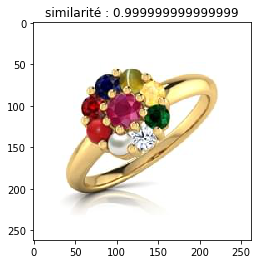

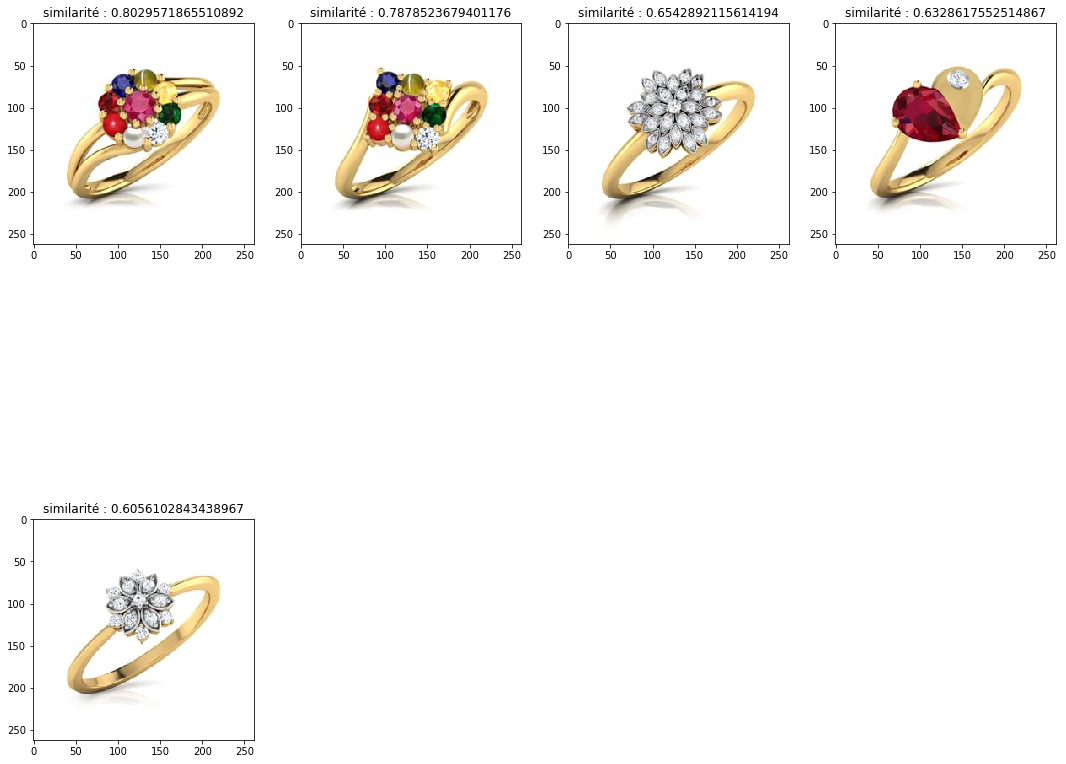

In [97]:
affichage_cosine(df_bijoux, autre, k, indice, voisins, distance, nom, cat_cible)

# T-SNE

In [25]:
tsne = TSNE(n_components=2, perplexity=10)
pca = PCA(50)

In [28]:
features = np.vstack(df_bijoux.loc[:,'features']) #récupération des features du data frame
pca_features = pca.fit_transform(features)
tsne_points = tsne.fit_transform(pca_features)

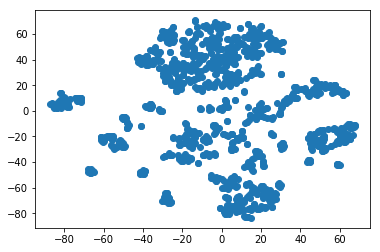

In [29]:
plt.scatter(tsne_points[:,0],tsne_points[:,1])

In [183]:
l_chemins = contenu_dossier("/home/bichet/Bureau/4A/Projet_RecomStyle/Jewellery")

In [184]:
#affichage de toutes les images sur un seul graphe

def imscatter(x, y, paths, ax=None, zoom=1, linewidth=0):
    if ax is None:
        plt.figure(figsize=(40,40))
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, p in zip(x, y, paths):
        try:
            im = imread(p)
        except:
            continue
        im = imresize(im,(80,80))
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data',
                            frameon=True, pad=0.1, 
                            bboxprops=dict(edgecolor='red',
                                           linewidth=linewidth));
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


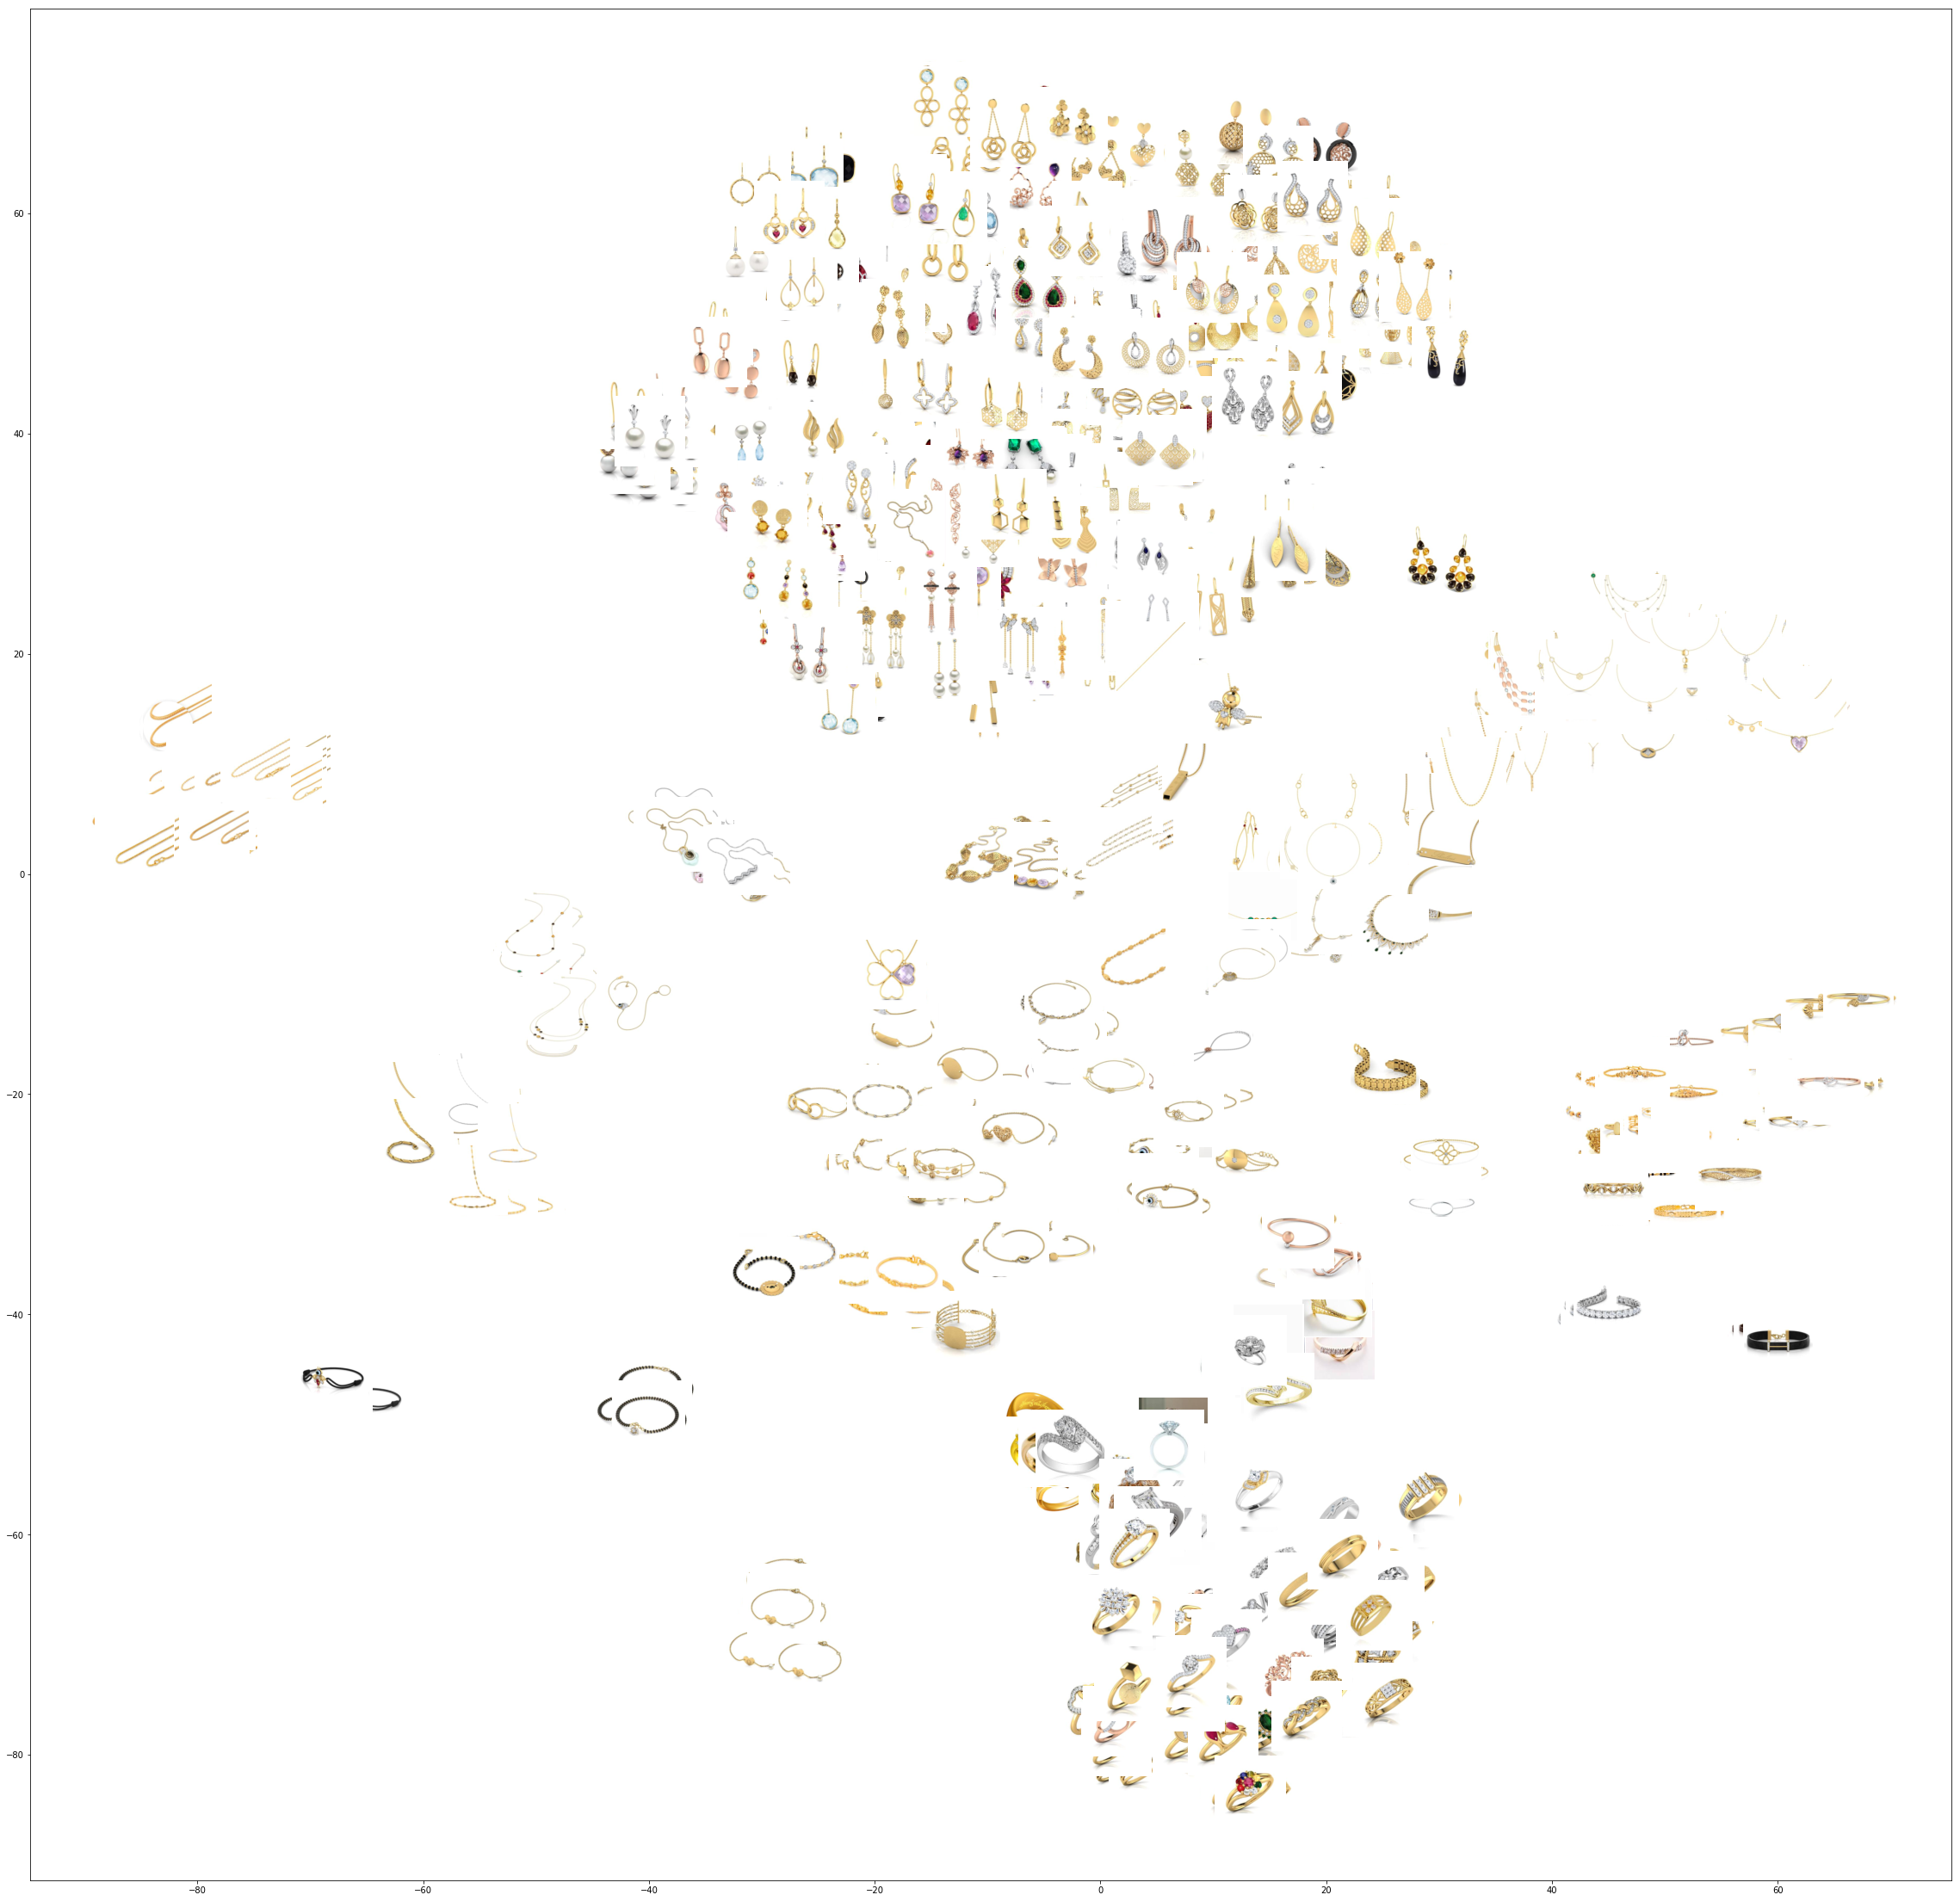

In [299]:
imscatter(tsne_points[:,0],tsne_points[:,1], l_chemins, ax=None, zoom=1, linewidth=0)
plt.savefig('tsne.png')
plt.show()
